# LIME meets attention 


Generates Figure 4 of the paper *Attention Meets Post-hoc Interpretability: A Mathematical Perspective*. 

In [1]:
import os
import pickle
import itertools 

import torch
import numpy as np

import matplotlib.pyplot as plt 
import math
from lime import lime_text

import re

In [2]:
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)
plt.rcParams.update({'font.size': 18})

In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
from models.utils import get_g_values
from models.utils import scaled_dot_product
from data.dataset import Dataset
import params

In [5]:
import sys
sys.path.append("C:/Users/gianl/Anaconda3/bin")

In [6]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model name and path
model_name = 'multi_head_e\\model'
model_path = os.path.join('.', 'models', 'saved', 'IMDB', model_name)

# Load the classifier model
with open(os.path.join(model_path, 'classifier.pkl'), 'rb') as inp:
    classifier = pickle.load(inp)
print(f"Model loaded successfully from: {model_path}")

Using device: cpu
Model loaded successfully from: .\models\saved\IMDB\multi_head_e\model


In [7]:
# Define the test size
test_size = 25000

# Import the IMDB dataset from torchtext
from torchtext.datasets import IMDB

# Load the IMDB dataset
dataset = Dataset(IMDB)

# Get the test subset
_, _, test_subset = dataset.get_subsets(0, 0, test_size)
print(f"Test subset: {len(test_subset)}")

Test subset: 25000


In [8]:
# Convert test subset to a NumPy array
sample = np.array(test_subset)

# Extract only the second column (text content)
texts = sample[:, 1]

In [9]:
n_heads = params.NUM_HEADS

In [10]:
# LIME initialization
lime_explainer = lime_text.LimeTextExplainer(class_names=['negative', 'positive'], mask_string=params.MASK)

In [11]:
doc = texts[7]
doc = re.sub('[^A-Za-z0-9]+', ' ', doc)

In [12]:
example = ' '.join(classifier.tokenizer(doc)[:params.MAX_LEN-1])

classifier.predict_proba([example])

array([[ 0.9287896, -1.093392 ]], dtype=float32)

In [13]:
example

'i find it amazing that so many people probably poles have voted for this movie giving it such grades mostly tens ok the movie was fine funny but it was nothing special on the other hand the only good thing about kiler is the dialogues rather not comprehensive for non poles screenplay is primitive the acting except for jerzy stuhr as ryba awful it s too much ado about nothing fortunately it s not included in the top 250 p s the sequel kilerow 2 och 2 kilers is on the way and it s just the same story'

In [14]:
def get_head(h):
    def head_classifier(x):
        head = classifier.heads[h]
        x = torch.stack([classifier.preprocess(t) for t in x])  # Preprocess the input text.
        with torch.no_grad():  # Disable gradient computation during prediction.
            emb = classifier.embedding(x.to(torch.int64))
            e = classifier.pe(emb)
            preds = head(e)  # Forward pass through the model.
        return preds
    return head_classifier

In [15]:
head_cls = [get_head(h) for h in range(n_heads)]
print(np.mean([head_cls[h]([example])[0,1] for h in range(n_heads)]))

-1.093392


## Veryfing LIME additivity 

In [16]:
lime_exp = []
for h in range(params.NUM_HEADS):
    lime_exp.append(dict(lime_explainer.explain_instance(example, head_cls[h], num_features=params.MAX_LEN-1).as_list()))

In [17]:
lime_exp_mh = lime_explainer.explain_instance(example, classifier.predict_proba, num_features=params.MAX_LEN-1)
lime_exp_mh = dict(lime_exp_mh.as_list())

In [18]:
lime_avg_heads = {}
for k in lime_exp_mh.keys():
    lime_avg_heads[k] = np.mean([lime_exp[h][k] for h in range(n_heads)])

In [19]:
num_tokens = 10
labels = list(lime_exp_mh.keys())[:num_tokens]

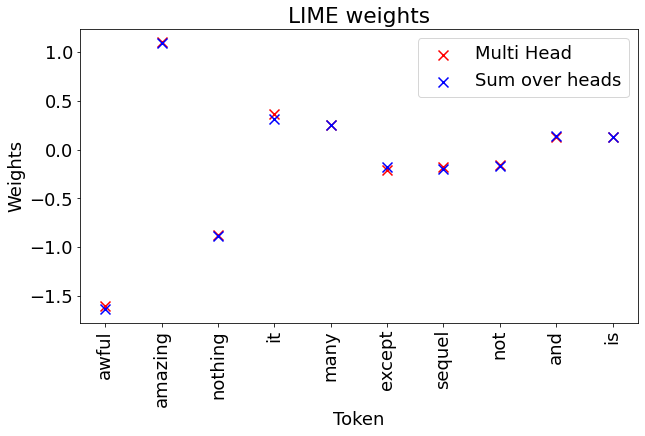

In [20]:
# Create a figure for visualization
plt.figure(figsize=(10, 6))

# Generate a box plot of the attention scores for each token
plt.title('LIME weights')
plt.xlabel('Token')
plt.xticks(rotation=90)
plt.ylabel('Weights')

# Overlay the approximated attention weights with red 'x' markers
plt.scatter(range(1, len(labels) + 1), np.array([lime_exp_mh[k] for k in labels]), marker='x', s=100, color='red', label='Multi Head')
plt.scatter(range(1, len(labels) + 1), np.array([lime_avg_heads[k] for k in labels]), marker='x', s=100, color='blue', label='Sum over heads')

# plt.labels(labels=labels)
plt.xticks(range(1, len(labels)+1), labels=labels)

# Adjust the bottom margin to accommodate all labels
plt.subplots_adjust(bottom=0.2)

plt.legend()

# Show the plot
plt.show()

## Veryfing approximation: Illustration of the accuracy of Eq. (19)

In [21]:
lime_rep = 5  # Number of LIME explanations to generate
lime_exp_dict = {}  # Dictionary to store aggregated LIME explanations
lime_avg_dict = {}  # Dictionary to store averages

# Generate multiple LIME explanations for the example sentence
for rep in range(lime_rep):

    # Generate LIME explanation for the current repetition
    lime_exp = lime_explainer.explain_instance(example, classifier.predict_proba, num_features=params.MAX_LEN-1)

    # Convert the LIME explanation to a dictionary
    lime_exp_dict_rep = dict(lime_exp.as_list())

    # Iterate over the explanation dictionary and aggregate values
    for key, value in lime_exp_dict_rep.items():
        # Check if the key already exists in the aggregated dictionary
        if key not in lime_exp_dict:
            lime_exp_dict[key] = []  # Initialize the value list if it doesn't exist

        # Append the current value to the corresponding key's value list
        lime_exp_dict[key].append(value)
        
# Calculate and store the average value for each key
for key, values in lime_exp_dict.items():
    if key not in lime_avg_dict:
        lime_avg_dict[key] = sum(values) / lime_rep
    else:
        lime_avg_dict[key] += sum(values) / lime_rep        
        
# Print the aggregated LIME explanation dictionary
print(f'Average LIME explanation over {lime_rep} repetitions:\n{lime_avg_dict}')

Average LIME explanation over 5 repetitions:
{'awful': -1.6081542207881134, 'amazing': 1.116125616759888, 'nothing': -0.8870189737423511, 'it': 0.3587613265644123, 'many': 0.25918481953767264, 'except': -0.21551649331952052, 'sequel': -0.18411474778002895, 'not': -0.17041060725906798, 'only': -0.11685755984779371, 'is': 0.12151455301029775, 'movie': -0.08295941920075216, 'and': 0.12758007934134952, 'i': -0.09092260534451284, 'as': 0.08779554117612505, 'find': -0.07690883303648671, 'just': -0.07076088040341894, 'ado': -0.056761875911738334, 'rather': -0.03994879850343075, 'probably': 0.06489178408448057, 'story': 0.03334377967852551, 'primitive': -0.027548318442662693, 'too': -0.053592430991732734, 'this': -0.03676407013071627, 'voted': 0.05906141361457895, 'dialogues': -0.04716854673006404, 'stuhr': -0.025509818399487898, 'fine': 0.014669118217275984, 'funny': 0.020339576435928288, 'non': -0.03880054679087908, 'thing': -0.03046003341018864, 'kilerow': 0.013933125199505467, 'tens': 0.01

In [22]:
unk_string = ' '.join([params.MASK for i in range(params.MAX_LEN-1)])

In [23]:
# Preprocess the input sentence
x = torch.stack([classifier.preprocess(example)])

v, q, k, attention, g_u = [], [], [], [], []
W_k, W_q, W_v, W, q_cls = [], [], [], [], []

    
emb = classifier.embedding(x.to(torch.int64))
e = classifier.pe(emb)

for h in range(params.NUM_HEADS):
    # Transform the sentence embedding using the embedding layer
    head = classifier.heads[h]


    # Extract query, key, and value representations from the embedding
    q.append(head.query(e))
    k.append(head.key(e))
    v.append(head.value(e))

    W_k.append(head.key(torch.eye(e.shape[-1])))
    W_q.append(head.query(torch.eye(e.shape[-1])))
    W_v.append(head.value(torch.eye(e.shape[-1])))
    W.append(head.classifier(torch.eye(v[h].shape[-1]))[:, 1])
    q_cls.append(q[h][:, classifier.cls_pos, :])

    # Calculate scaled dot-product attention
    values, alpha, g = scaled_dot_product(q[h], k[h], v[h], return_g=True, scale=True)
    
    attention.append(alpha)
    g_u.append(g[:, classifier.cls_pos, :])
    
    # Extract attention-weighted values for the classifier layer
    cls_values = values[:, classifier.cls_pos, :]

    # Pass the attention-weighted values through the classifier to obtain predictions
    output = head.classifier(cls_values)

    print(output)

tensor([[ 1.2851, -1.8672]], grad_fn=<MmBackward0>)
tensor([[-0.9658,  0.4816]], grad_fn=<MmBackward0>)
tensor([[ 5.0221, -6.1563]], grad_fn=<MmBackward0>)
tensor([[ 2.6124, -2.9471]], grad_fn=<MmBackward0>)
tensor([[ 0.1497, -0.0261]], grad_fn=<MmBackward0>)
tensor([[-2.5308,  3.9548]], grad_fn=<MmBackward0>)


In [24]:
# Preprocess the "UNK" token
x_unk = torch.stack([classifier.preprocess(unk_string)])

v_unk, q_unk, k_unk, g_unk = [], [], [], []

# Convert the "UNK" token to embedding representation
emb = classifier.embedding(x_unk.to(torch.int64))
e_unk = classifier.pe(emb)


for h in range(n_heads):
    # Extract the hidden state (h) from the "UNK" token embedding
    head = classifier.heads[h]
    
    v_unk.append(head.value(e_unk)) # + classifier.value(classifier.pe(x_unk.to(torch.int64)))
    q_unk.append(head.query(e_unk)) # + classifier.query(classifier.pe(x_unk.to(torch.int64)))
    k_unk.append(head.key(e_unk)) # + classifier.key(classifier.pe(x_unk.to(torch.int64)))
    
    d_k = q_unk[h].size()[-1]
    attn_logits = torch.matmul(q[h], k_unk[h].transpose(-2, -1)) / math.sqrt(d_k)
    g_unk.append(torch.exp(attn_logits)[:, classifier.cls_pos, :])

In [25]:
tokens = classifier.tokenizer(example)
token_pos = {}  # Dictionary to store token positions
for i, token in enumerate(tokens):
    if i < params.MAX_LEN - 1:
        if token not in token_pos:  # Check if token exists in the dictionary
            token_pos[token] = []  # Initialize an empty list for the token
        token_pos[token].append(i + 1)  # Append the current position to the token's list
        
print(dict(sorted(token_pos.items())))

{'2': [85, 87], '250': [79], 'about': [41, 69], 'acting': [56], 'ado': [68], 'amazing': [4], 'and': [93], 'as': [61], 'awful': [63], 'but': [28], 'comprehensive': [48], 'dialogues': [45], 'except': [57], 'find': [2], 'fine': [26], 'for': [13, 49, 58], 'fortunately': [71], 'funny': [27], 'giving': [16], 'good': [39], 'grades': [19], 'hand': [36], 'have': [11], 'i': [1], 'in': [76], 'included': [75], 'is': [43, 53, 89], 'it': [3, 17, 29, 64, 72, 94], 'jerzy': [59], 'just': [96], 'kiler': [42], 'kilerow': [84], 'kilers': [88], 'many': [7], 'mostly': [20], 'movie': [15, 24], 'much': [67], 'non': [50], 'not': [47, 74], 'nothing': [31, 70], 'och': [86], 'ok': [22], 'on': [33, 90], 'only': [38], 'other': [35], 'p': [80], 'people': [8], 'poles': [10, 51], 'primitive': [54], 'probably': [9], 'rather': [46], 'ryba': [62], 's': [65, 73, 81, 95], 'same': [98], 'screenplay': [52], 'sequel': [83], 'so': [6], 'special': [32], 'story': [99], 'stuhr': [60], 'such': [18], 'tens': [21], 'that': [5], 'the

In [26]:
lime_approx = {}  # Dictionary to store approximate LIME scores for tokens

for token in token_pos.keys():
    # Calculate the approximate LIME score for the current token
    approx_score = 3/2 * np.mean(
        [np.sum(
            [
        float((torch.matmul((attention[h][:, classifier.cls_pos, t] * v[h][:, t, :] - 
              g_unk[h][:,t] * v_unk[h][:, t, :] / torch.sum(g_unk[h])), 
             W[h])))
        for t in token_pos[token]
    ])
        for h in range(params.NUM_HEADS)  
    ])                       
        
    # Store the approximate LIME score for the token in the dictionary
    lime_approx[token] = approx_score
    
print(lime_approx)

{'i': -0.006039100524503738, 'find': -0.009068961131561082, 'it': 0.28466610366740497, 'amazing': 1.0026591444693622, 'that': -0.003360951490321895, 'so': -0.004450708824151661, 'many': 0.2013954095527879, 'people': -0.008128751796903089, 'probably': -0.0004088462155777961, 'poles': 0.0007389582336827516, 'have': -0.004635323479305953, 'voted': -0.0013600752099591773, 'for': 0.0020777580630237935, 'this': -0.0033294855966232717, 'movie': -0.08896815640036948, 'giving': -0.0014583452020815457, 'such': -0.005533543094315974, 'grades': -0.0014528579780517248, 'mostly': -0.0032523650725124753, 'tens': -0.0027890249111806042, 'ok': 0.0005548391127376817, 'the': 0.020992964138940806, 'was': 0.002875249439966865, 'fine': -0.00030544328183168545, 'funny': 0.000528690819919575, 'but': 0.00010442694474477321, 'nothing': -0.5688693760930619, 'special': 0.002919339265645249, 'on': -0.0016689124954609724, 'other': 0.0010363932469772408, 'hand': 0.00013790561752102803, 'only': -0.059570969111518934,

In [27]:
num_tokens = 10
labels = list(lime_exp_dict.keys())[:num_tokens]

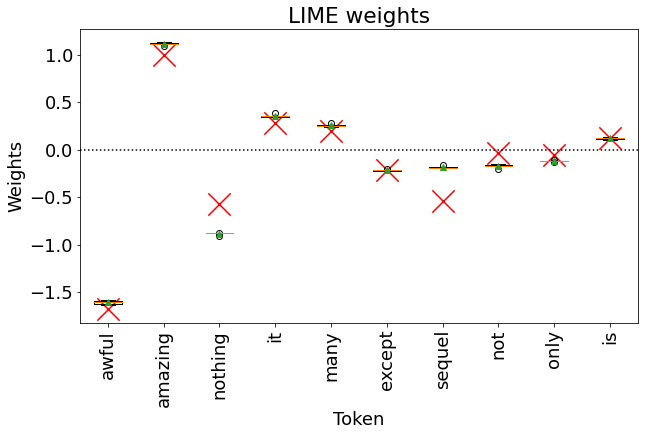

In [28]:
# Create a figure for visualization
plt.figure(figsize=(10, 6))

# Generate a box plot of the attention scores for each token
plt.boxplot(list(lime_exp_dict.values())[:num_tokens], labels=labels, showmeans=True)
plt.title('LIME weights')
plt.xlabel('Token')
plt.xticks(rotation=90)
plt.ylabel('Weights')

# Overlay the approximated attention weights with red 'x' markers
plt.scatter(range(1, len(labels) + 1), np.array([lime_approx[k] for k in labels]), marker='x', s=500, color='red')

# Add a dotted horizontal line at y=0
plt.axhline(0, color='black', linestyle='dotted')

# Adjust the bottom margin to accommodate all labels
plt.subplots_adjust(bottom=0.2)

# Show the plot
plt.show()